In [1]:
from models.SSD300 import SSD300
import tensorflow as tf
import numpy as np
keras = tf.keras

# Verify SSD shapes

In [2]:
SSD300_model = SSD300(21)

In [3]:
SSD300_cone = SSD300_model.getCone()
SSD300_cone.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 38, 38, 512)       7635264   
_________________________________________________________________
sequential_1 (Sequential)    (None, 19, 19, 512)       7079424   
_________________________________________________________________
FC6_to_Conv6 (Conv2D)        (None, 19, 19, 1024)      4719616   
_________________________________________________________________
FC7_to_Conv7 (Conv2D)        (None, 19, 19, 1024)      1049600   
_________________________________________________________________
Conv8_1 (Conv2D)             (None, 19, 19, 256)       262400    
_________________________________________________________________
Conv8_2 (Conv2D)             (None, 10, 10, 512)       1180160   
_________________________________________________________________
Conv9_1 (Conv2D)             (None, 10, 10, 128)      

In [9]:
test_input = tf.ones((20, 300, 300, 3), dtype=SSD300_model.floatType, name=None)
confs, locs = SSD300_model(test_input)

In [10]:
# after reshape
stages = [4, 7, 8, 9, 10, 11]
for i in range(len(confs)):
    print("[Stage {}] Convolutions shape for confidence: {}, for localization: {}, number of boxes: {}".format(
        stages[i],
        confs[i].shape,
        locs[i].shape,
        SSD300_model.default_boxes_per_stage[i].shape))

[Stage 4] Convolutions shape for confidence: (20, 5776, 21), for localization: (20, 5776, 4), number of boxes: (5776, 4)
[Stage 7] Convolutions shape for confidence: (20, 2166, 21), for localization: (20, 2166, 4), number of boxes: (2166, 4)
[Stage 8] Convolutions shape for confidence: (20, 600, 21), for localization: (20, 600, 4), number of boxes: (600, 4)
[Stage 9] Convolutions shape for confidence: (20, 150, 21), for localization: (20, 150, 4), number of boxes: (150, 4)
[Stage 10] Convolutions shape for confidence: (20, 36, 21), for localization: (20, 36, 4), number of boxes: (36, 4)
[Stage 11] Convolutions shape for confidence: (20, 4, 21), for localization: (20, 4, 4), number of boxes: (4, 4)


In [11]:
for i in range(len(confs)):
    print("[Stage {}] number of boxes: {}, max value {}".format(
        stages[i],
        SSD300_model.default_boxes_per_stage[i].shape,
        tf.reduce_max(SSD300_model.default_boxes[i])))

[Stage 4] number of boxes: (5776, 4), max value 0.05000000074505806
[Stage 7] number of boxes: (2166, 4), max value 0.10000000149011612
[Stage 8] number of boxes: (600, 4), max value 0.1414213627576828
[Stage 9] number of boxes: (150, 4), max value 0.1414213627576828
[Stage 10] number of boxes: (36, 4), max value 0.05000000074505806
[Stage 11] number of boxes: (4, 4), max value 0.10000000149011612


In [12]:
SSD300_model.default_boxes_per_stage[4]

<tf.Tensor: shape=(36, 4), dtype=float64, numpy=
array([[0.16666667, 0.16666667, 0.3625    , 0.3625    ],
       [0.16666667, 0.16666667, 0.725     , 0.725     ],
       [0.16666667, 0.16666667, 1.02530483, 0.51265242],
       [0.16666667, 0.16666667, 0.51265242, 1.02530483],
       [0.5       , 0.16666667, 0.3625    , 0.3625    ],
       [0.5       , 0.16666667, 0.725     , 0.725     ],
       [0.5       , 0.16666667, 1.02530483, 0.51265242],
       [0.5       , 0.16666667, 0.51265242, 1.02530483],
       [0.83333333, 0.16666667, 0.3625    , 0.3625    ],
       [0.83333333, 0.16666667, 0.725     , 0.725     ],
       [0.83333333, 0.16666667, 1.02530483, 0.51265242],
       [0.83333333, 0.16666667, 0.51265242, 1.02530483],
       [0.16666667, 0.5       , 0.3625    , 0.3625    ],
       [0.16666667, 0.5       , 0.725     , 0.725     ],
       [0.16666667, 0.5       , 1.02530483, 0.51265242],
       [0.16666667, 0.5       , 0.51265242, 1.02530483],
       [0.5       , 0.5       , 0.3625 

In [13]:
SSD300_model.default_boxes.shape

TensorShape([8732, 4])

In [14]:
tf.concat(locs, axis=1).shape

TensorShape([20, 8732, 4])

In [15]:
tf.concat(confs, axis=1).shape

TensorShape([20, 8732, 21])

In [16]:
from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection

manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")

imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

In [17]:
from models.SSD300 import SSD300
import tensorflow as tf
SSD300_model = SSD300(21)
confs, locs = SSD300_model(imgs)
confs_pred = tf.concat(confs, axis=1)
locs_pred = tf.concat(locs, axis=1)

In [19]:
boxes, classes, scores = SSD300_model.getPredictionsFromConfsLocs(confs_pred+0.185, locs_pred, box_encoding="corner")

In [20]:
for box in boxes:
    print(box.shape)

(1172, 4)
(443, 4)
(298, 4)
(352, 4)
(231, 4)


# Test NMS

In [21]:
from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection
manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

from models.SSD300 import SSD300
import tensorflow as tf
SSD300_model = SSD300(21)
confs, locs = SSD300_model(imgs)
SSD300_model.load_weights("../data/weights_alldata/ssd_weights_epoch_0390.h5")

In [22]:
confs, locs = SSD300_model(imgs)
confs_pred = tf.concat(confs, axis=1)
locs_pred = tf.concat(locs, axis=1)
confs_pred = tf.math.softmax(confs_pred, axis=-1)
boxes, classes, scores = SSD300_model.getPredictionsFromConfsLocs(confs_pred, locs_pred, score_threshold=0.0)

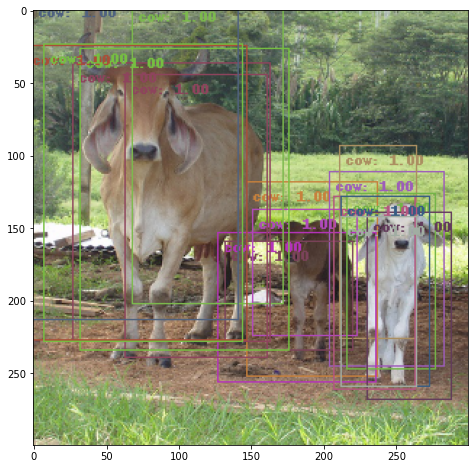

In [23]:
from utils.eval import *
idx_img = 1
pltPredOnImg(imgs[idx_img]*255, boxes[idx_img], classes[idx_img], scores[idx_img],  manager)

In [24]:
print(boxes[idx_img].shape, classes[idx_img].shape, scores[idx_img].shape)
boxes_pred, classes_pred, scores_pred = SSD300_model.recursive_nms(boxes[idx_img],
                                                                   classes[idx_img],
                                                                   scores[idx_img])
boxes_pred.shape, classes_pred.shape, scores_pred.shape

(18, 4) (18,) (18,)


(TensorShape([3, 4]), TensorShape([3]), TensorShape([3]))

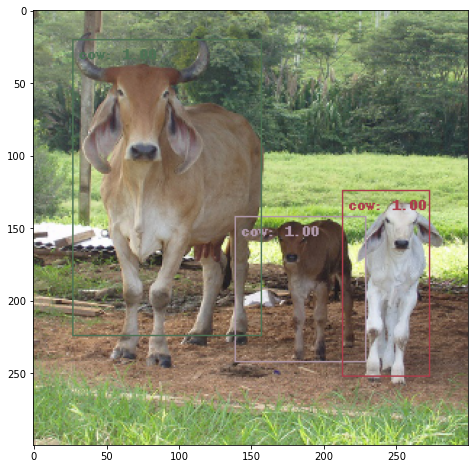

In [25]:
from utils.eval import *
pltPredOnImg(imgs[idx_img]*255, boxes_pred, classes_pred, scores_pred,  manager)

# Infer on images from batch

In [26]:
from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection
manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

from models.SSD300 import SSD300
import tensorflow as tf
SSD300_model = SSD300(21)
confs, locs = SSD300_model(imgs)

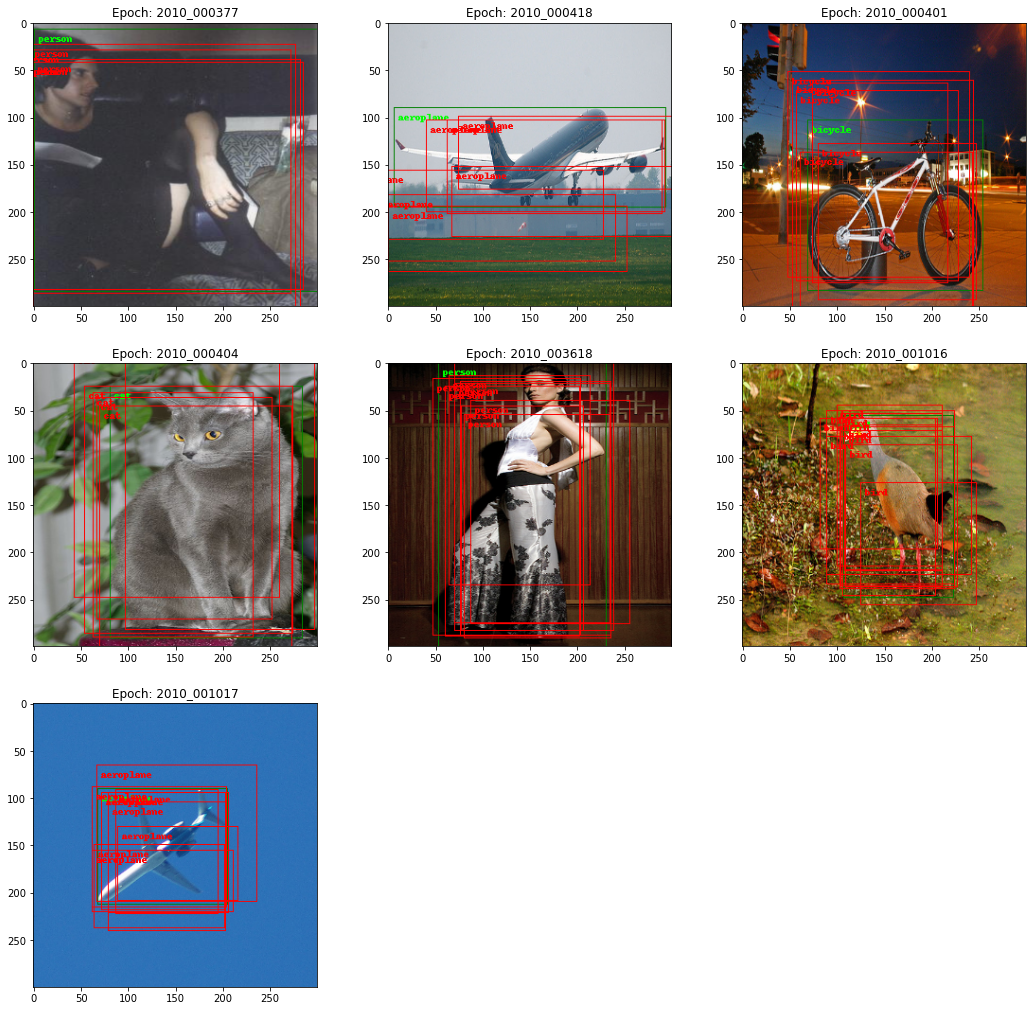

In [27]:
from utils.eval import *
SSD300_model.load_weights("../data/weights_alldata/ssd_weights_epoch_0390.h5")
batch = manager.batches[250][4:5] + manager.batches[250][24:25] + manager.batches[250][18:20] + manager.batches[300][17:18] + manager.batches[260][5:7]
pltPredGt(SSD300_model, manager, batch, score_threshold=0.9, draw_default=False)

# Infer on video

In [28]:
%load_ext autoreload
%autoreload 2

In [37]:
from utils.eval import *

from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection
manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

from models.SSD300 import SSD300
import tensorflow as tf
SSD300_model = SSD300(21)
confs, locs = SSD300_model(imgs)

SSD300_model.load_weights("../data/weights_alldata/ssd_weights_epoch_0390.h5")

out_path = "imgs/"

In [54]:
video_path = "imgs/skate.mp4"
pltPredOnVideo(SSD300_model, manager, video_path, out_path + "skate_detection.gif", score_threshold=0.95,
               start_idx=130, end_idx=250, nms=True, skip=3)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 21.59it/s]


In [53]:
video_path = "imgs/person_dog.mp4"
pltPredOnVideo(SSD300_model, manager, video_path, out_path + "person_dog_detection.gif",
                         score_threshold=0.95, start_idx=50, end_idx=180, nms=True, skip=3, fps=40)

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:13<00:00, 13.59it/s]


# Infer with different weights

100%|█████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.83it/s]


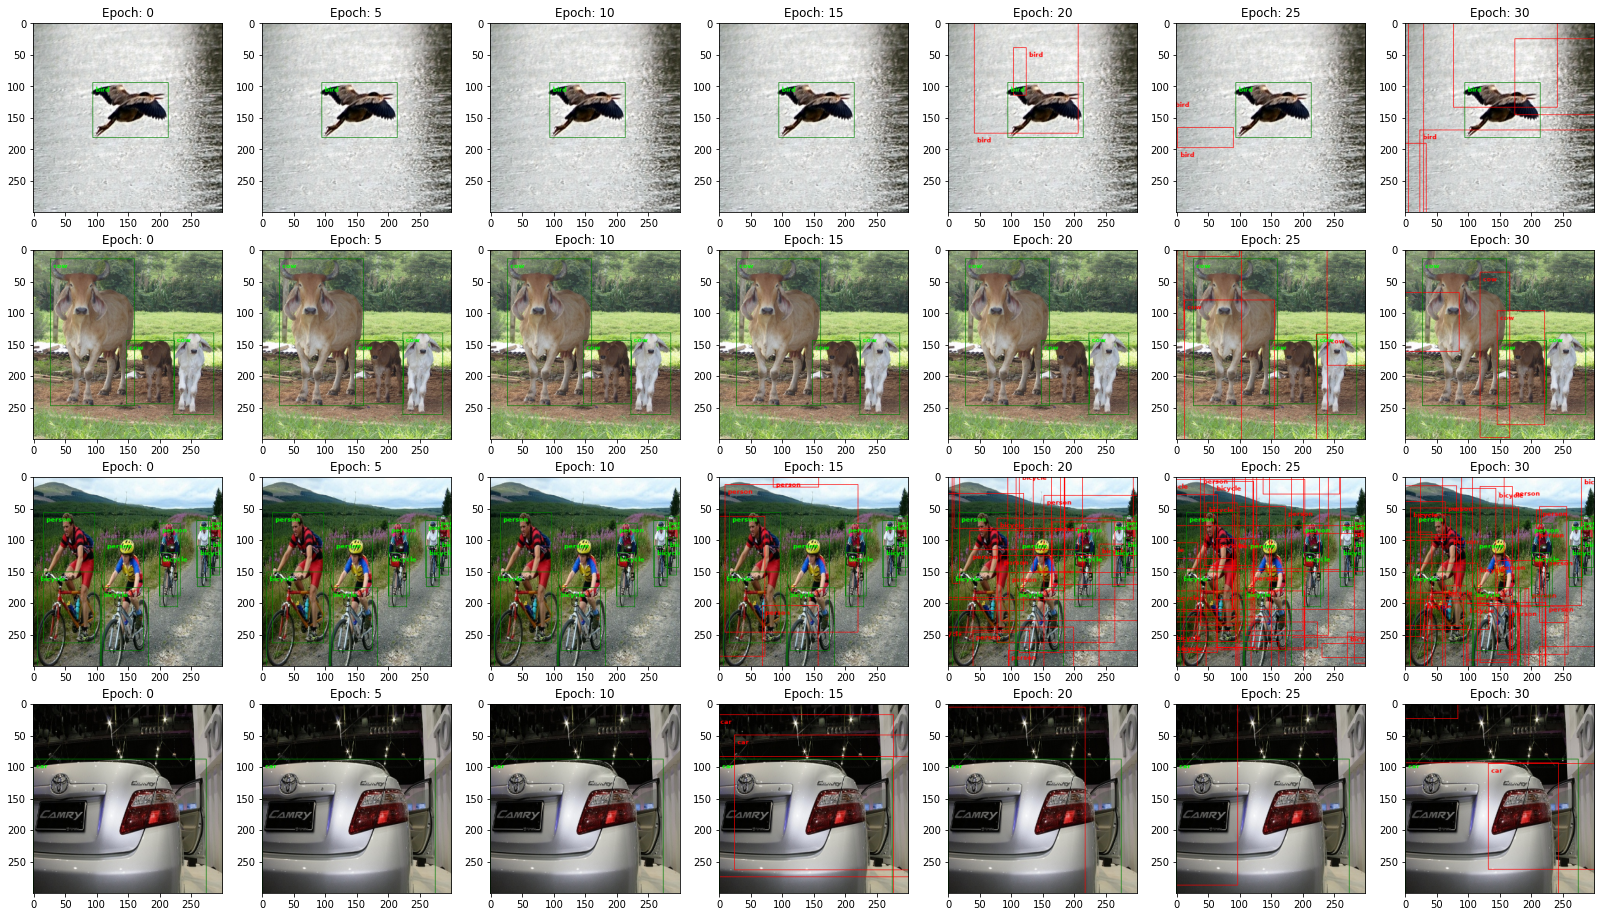

In [30]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

w=40
h=40
skip = 5
weights_files = glob("../weights/*")[0::skip]
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:19])
columns = len(weights_files)
rows = len(imgs)
fnt = ImageFont.truetype("DejaVuSans-Bold.ttf", 10)
size = 4
fig=plt.figure(figsize=(columns*size, rows*size))

num_pic = 1

for j, img in enumerate(imgs):
    img_ssd = tf.expand_dims(img, 0)
    for i, weights in enumerate(tqdm(weights_files)):
        SSD300_model.load_weights(weights)
        confs, locs = SSD300_model(img_ssd)
        confs_pred = tf.concat(confs, axis=1)
        locs_pred = tf.concat(locs, axis=1)
        confs_pred = tf.math.softmax(confs_pred, axis=2)
        classes, boxes = SSD300_model.getPredictionsFromConfsLocs(confs_pred, locs_pred,
                                                                  score_threshold=0.8,
                                                                  box_encoding="corner")
        fig.add_subplot(rows, columns, num_pic)
        img_res = img*255
        img_pil = Image.fromarray(img_res.numpy().astype(np.uint8))
        draw = ImageDraw.Draw(img_pil)
        for b, box in enumerate(boxes[0]):
            min_point = int(box[0] * 300), int(box[1] * 300)
            end_point = int(box[2] * 300), int(box[3] * 300)
            draw.rectangle((min_point, end_point), outline='red')
            cat = list(manager.classes.keys())[classes[0][b]]
            draw.text((min_point[0]+5,min_point[1]+5), cat, font=fnt, fill=(255,0,0,0))
        for b, box in enumerate(boxes_gt[j]):
            box = tf.concat([box[:2] - box[2:] / 2,
                             box[:2] + box[2:] / 2], axis=-1)
            min_point = int(box[0] * 300), int(box[1] * 300)
            end_point = int(box[2] * 300), int(box[3] * 300)
            draw.rectangle((min_point, end_point), outline='green')
            draw.text((min_point[0]+5,min_point[1]+5), list(manager.classes.keys())[classes_gt[j][b]] , font=fnt, fill=(0,255,0,0))
        plt.title("Epoch: {}".format(i*skip))
        plt.imshow(img_pil)
        num_pic += 1
plt.show()
